A1 - Entropy of target

In [1]:
import pandas as pd, numpy as np
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load dataset
df13 = pd.read_csv("processed_fluency_dataset.csv")

# A1 – Entropy of Target
def entropy13(y):
    probs13 = y.value_counts(normalize=True)
    return -sum(p1 * log2(p1) for p1 in probs13 if p1 > 0)

print(" Entropy of fluency:", round(entropy13(df13["fluency"].astype(str)), 4))

 Entropy of fluency: 1.1164


Gini index of target

In [2]:
def gini_index13(y):
    probs13 = y.value_counts(normalize=True)
    return 1 - sum(p1**2 for p1 in probs13)

print(" Gini Index of fluency:", round(gini_index13(df13["fluency"].astype(str)), 4))

 Gini Index of fluency: 0.4993


A3 — Best root attribute (Equal-width binning)

In [3]:
def equal_width_binning13(s, bins=4):
    return pd.cut(s, bins=bins, include_lowest=True, duplicates="drop").astype(str)

def information_gain13(y, x_binned):
    return entropy13(y) - sum((len(y[x_binned==v])/len(y))*entropy13(y[x_binned==v]) for v in x_binned.unique())

target13 = df13["fluency"].astype(str)
exclude_cols13 = {"filename", "student_id", "type", "fluency", "fluency_encoded"}
features13 = [c for c in df13.columns if c not in exclude_cols13]

best_feature13, best_gain13 = None, -1
for f in features13:
    labels = equal_width_binning13(df13[f]) if pd.api.types.is_numeric_dtype(df13[f]) else df13[f].astype(str)
    gain = information_gain13(target13, labels)
    if gain > best_gain13:
        best_feature13, best_gain13 = f, gain

print(f" Best root attribute: {best_feature13} | Gain: {round(best_gain13, 4)}")

 Best root attribute: rms | Gain: 0.123


A4 — Best root attribute (Equal-frequency binning)

In [4]:
def bin_feature13(series13, method13="equal_width", bins=4):
    if method13 == "equal_width":
        return pd.cut(series13, bins=bins, labels=False, include_lowest=True, duplicates="drop")
    elif method13 == "equal_freq":
        return pd.qcut(series13, q=bins, labels=False, duplicates="drop")

def find_best_feature_with_binning13(data13, target13, method13="equal_width", bins=4):
    feats13 = [c for c in data13.columns if c not in {target13, "filename", "student_id", "fluency_encoded"}]
    best_f13, best_ig13 = None, -1
    for f in feats13:
        temp13 = data13.copy()
        if pd.api.types.is_numeric_dtype(temp13[f]):
            temp13[f] = bin_feature13(temp13[f], method13, bins)
        ig_val13 = information_gain13(temp13[target13], temp13[f])
        if ig_val13 > best_ig13:
            best_f13, best_ig13 = f, ig_val13
    return best_f13, best_ig13

bf13, ig_val13 = find_best_feature_with_binning13(df13.copy(), "fluency", method13="equal_freq", bins=4)
print(f" Best root feature: {bf13} | IG: {round(ig_val13, 4)}")

 Best root feature: rms | IG: 0.2907


A5 — Build and evaluate our own Decision Tree

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#  Decision Tree Classes
class DTNode:
    def __init__(self, leaf=False, pred=None, feat=None, kids=None, edges=None):
        self.leaf, self.pred, self.feat, self.kids, self.edges = leaf, pred, feat, kids or {}, edges

class SimpleDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, bins=4):
        self.md, self.ms, self.bins, self.root = max_depth, min_samples_split, bins, None

    def _majority13(self, y):
        return y.mode()[0]

    def _fit13(self, X, y, feats, d):
        if len(y.unique()) == 1 or d >= self.md or len(y) < self.ms or not feats:
            return DTNode(True, self._majority13(y))

        bf13, bg13, bl_best13, be_best13 = None, -1, None, None
        for f in feats:
            if pd.api.types.is_numeric_dtype(X[f]):
                bl13, be13 = pd.cut(X[f], bins=self.bins, retbins=True, include_lowest=True, duplicates="drop")
                bl13 = bl13.astype(str)
            else:
                bl13, be13 = X[f].astype(str), None

            g13 = information_gain13(y, bl13)   # assumes you have this function defined
            if g13 > bg13:
                bf13, bg13, bl_best13, be_best13 = f, g13, bl13, be13

        if not bf13:
            return DTNode(True, self._majority13(y))

        kids = {
            v: self._fit13(X[bl_best13 == v], y[bl_best13 == v],
                           [f for f in feats if f != bf13], d + 1)
            for v in bl_best13.unique()
        }
        return DTNode(False, None, bf13, kids, be_best13)

    def fit13(self, X, y):
        self.root = self._fit13(X, y, list(X.columns), 0)
        return self

    def _predict_one13(self, row, node):
        if node.leaf:
            return node.pred
        v = row[node.feat]
        if node.edges is not None and len(node.edges) > 0:
            try:
                v = float(v)
                for i in range(len(node.edges) - 1):
                    if node.edges[i] <= v <= node.edges[i + 1]:
                        v = f"({node.edges[i]}, {node.edges[i + 1]}]"
                        break
            except ValueError:
                v = str(v)
        else:
            v = str(v)
        return self._predict_one13(row, node.kids.get(str(v), list(node.kids.values())[0]))

    def predict13(self, X):
        return [self._predict_one13(X.iloc[i], self.root) for i in range(len(X))]


# Train & Test
X_train13, X_test13, y_train13, y_test13 = train_test_split(df13[features13], target13, stratify=target13, test_size=0.25, random_state=42)

tree13 = SimpleDecisionTree(max_depth=5, min_samples_split=5, bins=4).fit13(X_train13, y_train13)
y_pred13 = tree13.predict13(X_test13)

print("A5) Accuracy:", round(accuracy_score(y_test13, y_pred13), 4))
print(classification_report(y_test13, y_pred13))


A5) Accuracy: 0.3708
              precision    recall  f1-score   support

     Average       0.37      0.98      0.54       242
      Fluent       0.00      0.00      0.00        19
        Poor       0.80      0.02      0.04       397

    accuracy                           0.37       658
   macro avg       0.39      0.33      0.19       658
weighted avg       0.62      0.37      0.22       658



A6 — Visualize Decision Tree using sklearn

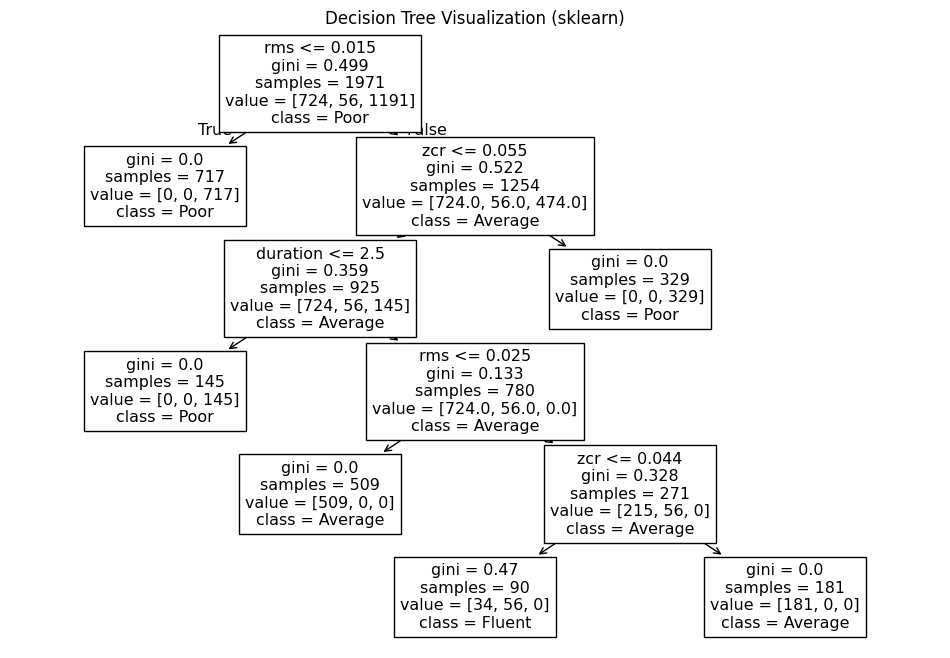

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load dataset
df13 = pd.read_csv("processed_fluency_dataset.csv")
TARGET_COL13 = "fluency"
exclude_cols13 = {"filename", "student_id", "type", "fluency", "fluency_encoded"}
feature_cols13 = [c for c in df13.columns if c not in exclude_cols13]
X = df13[feature_cols13].copy()
y = df13[TARGET_COL13].astype(str)

# Clean 'tempo' column if it looks like "[number]"
def extract_first_number13(x):
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            return float(x.strip("[]").split(",")[0])
        except:
            return np.nan
    return x

if "tempo" in X.columns:
    X["tempo"] = X["tempo"].apply(extract_first_number13)

# Fill missing numeric values with median
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())

# Train-test split
X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Train sklearn Decision Tree
sk_tree13 = DecisionTreeClassifier(max_depth=5, random_state=42)
sk_tree13.fit(X_train13, y_train13)

# Plot tree
plt.figure(figsize=(12, 8))
plot_tree(sk_tree13, feature_names=list(X_train13.columns), class_names=sorted(y.unique()), filled=False)
plt.title("Decision Tree Visualization (sklearn)")
plt.show()

A7 — Decision Boundary (2 features, custom decision tree)

/tmp/ipython-input-3465635583.py:34: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  Z = pd.factorize(tree2.predict13(grid))[0].reshape(xx.shape)


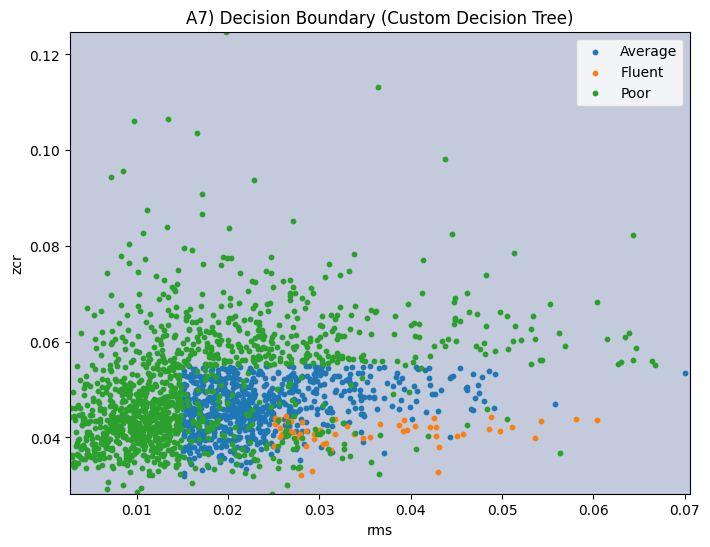

In [10]:
# Function to convert "[value]" strings to float
def extract_first_number(x):
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            return float(x.strip("[]").split(",")[0])
        except:
            return np.nan
    return x

# Select two features
two_feats = ["rms", "zcr"]
X2 = df13[two_feats].copy()
y2 = target13

# Convert both features to numeric if needed
for feat in two_feats:
    X2[feat] = X2[feat].apply(extract_first_number)
    if pd.api.types.is_numeric_dtype(X2[feat]):
        X2[feat] = X2[feat].fillna(X2[feat].median())

# Train/test split
Xtr, _, ytr, _ = train_test_split(X2, y2, stratify=y2, test_size=0.25, random_state=42)

# Train custom tree
tree2 = SimpleDecisionTree(max_depth=3, min_samples_split=5, bins=4).fit13(Xtr, ytr)

# Create grid for decision boundary
x_min, x_max = X2[two_feats[0]].min(), X2[two_feats[0]].max()
y_min, y_max = X2[two_feats[1]].min(), X2[two_feats[1]].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),np.linspace(y_min, y_max, 300))
grid = pd.DataFrame({two_feats[0]: xx.ravel(), two_feats[1]: yy.ravel()})

# Predict over grid
Z = pd.factorize(tree2.predict13(grid))[0].reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
for cls in sorted(y2.unique()):
    idx = ytr == cls
    plt.scatter(Xtr.loc[idx, two_feats[0]], Xtr.loc[idx, two_feats[1]], s=10, label=cls)
plt.xlabel(two_feats[0])
plt.ylabel(two_feats[1])
plt.title("A7) Decision Boundary (Custom Decision Tree)")
plt.legend()
plt.show()
